# Gen AI apps: Deploy LangChain on Cloud Run with LangServe

CREDITS: https://cloud.google.com/blog/products/ai-machine-learning/deploy-langchain-on-cloud-run-with-langserve?utm_source=youtube&utm_medium=unpaidsoc&utm_campaign=CDR_ram_aiml_rxvkn6uajio_NextLangChain_041224&utm_content=description

## Introducción

LangChain es uno de los frameworks más populares que facilita construir aplicaciones basadas en LLMs. En 2023, LangChain introdujo LangServe (https://blog.langchain.dev/introducing-langserve/), una manera de desplegar cualquier proyecto LangChain como API REST. Y hasta la fecha, Cloud Run es la mejor opción para pasar estos proyectos a producción.

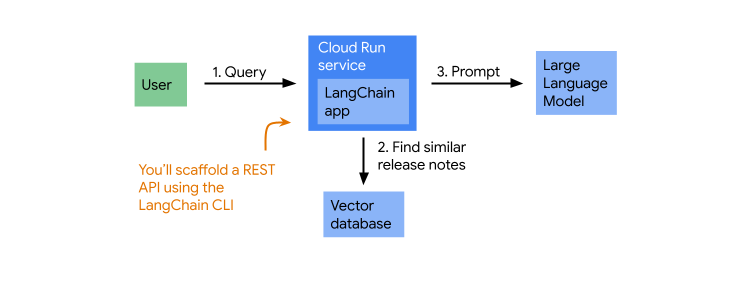

## Background

**Un poco de overview de cómo funcionan las aplicaciones basadas en Gen AI...**

Los chatbots de IA generativa, como ChatGPT, estan basados en modelos de lenguaje (LLM). Por lo general, cuando preguntas a un LLM utilizando un prompt este de devolverá una respuesta. Al ser modelos probabilísticos lo podrías llegar a entender cómo un  "autocompletado avanzado", aunque es una forma muy simplificada de pensarlo. De hecho tienen muchas otras características, como escribir código, reformular texto, generar recomendaciones y resolver problemas lógicos simples, aunque también puedes enviar prompts a un LLM desde tu código, lo que puede resultar muy útil cuando empieces a integrarte con tus propios datos y APIs. 

## Hands-on: Construyendo chains con LangChain

LangChain ofrece todas las abstracciones que necesitas para empezar a construir una aplicación basada en LLMs. Está formado por muchos componentes (https://js.langchain.com/v0.2/docs/integrations/components/) entre los que se incluyen los LLM, los Document Loaders, Text Embeddings, Vector Stores, Agents, etc. Y existen muchos productos de Google ya integrados (https://python.langchain.com/v0.2/docs/integrations/platforms/google/).

En este proyecto se va a desplegar una aplicación basada en LangChain que utiliza el modelo Gemini de Google para hacer preguntas de la documentación de Cloud Run. Vamos a ello:

### 1. Setup y requerimientos para que el entorno funcione bien:
https://codelabs.developers.google.com/codelabs/build-and-deploy-a-langchain-app-on-cloud-run#1

### 2. Crea una instancia de una vector database POSTGRESQL:
https://codelabs.developers.google.com/codelabs/build-and-deploy-a-langchain-app-on-cloud-run#2

El siguiente paso es crear la aplicación en LangChain utilizando LangChain CLI. LangChain CLI permite iniciar un proyecto de manera rápida gracias a LangServe. Necesitas tener instalado la versión más reciente. De nombre de la aplicación puedes poner el que quieras, por ejemplo, run-rag, y omite instalar otros paquetes omitiendo la instalación:

In [ ]:
#!pip install langchain-cli poetry

Muévete al directorio del prouecto e instala las dependencias:

In [1]:
# poetry install

NOTA: Hay muchas plantillas pre-instaladas que puedes utilizar, en LangChain Templates puedes verlas todas: https://templates.langchain.com/

### 3. Creamos el Cloud Run Job indexing

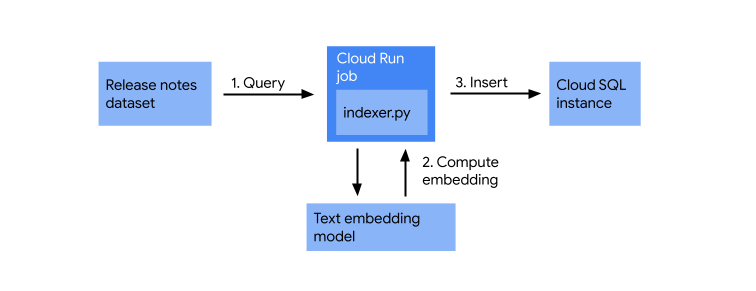

indexer.py será el responsable de coger la documentación, convertirla en vectores usando un modelo de text embeddings, y guardarlo en nuestra base de datos vectorizada POSTGRESQL. Esto permite una búsqueda eficiente de documentación simlar basado en similitud semántica.

En la carpeta run-rag/app, crea un archivo que se llame indexer.py con el siguiente contenido:

In [ ]:
import os
from google.cloud.sql.connector import Connector
import pg8000
from langchain_community.vectorstores.pgvector import PGVector
from langchain_google_vertexai import VertexAIEmbeddings
from google.cloud import bigquery


# Retrieve all Cloud Run release notes from BigQuery 
client = bigquery.Client()
query = """
SELECT
  CONCAT(FORMAT_DATE("%B %d, %Y", published_at), ": ", description) AS release_note
FROM `bigquery-public-data.google_cloud_release_notes.release_notes`
WHERE product_name= "Cloud Run"
ORDER BY published_at DESC
"""
rows = client.query(query)

print(f"Number of release notes retrieved: {rows.result().total_rows}")

# Set up a PGVector instance 
connector = Connector()

def getconn() -> pg8000.dbapi.Connection:
    conn: pg8000.dbapi.Connection = connector.connect(
        os.getenv("DB_INSTANCE_NAME", ""),
        "pg8000",
        user=os.getenv("DB_USER", ""),
        password=os.getenv("DB_PASS", ""),
        db=os.getenv("DB_NAME", ""),
    )
    return conn

store = PGVector(
    connection_string="postgresql+pg8000://",
    use_jsonb=True,
    engine_args=dict(
        creator=getconn,
    ),
    embedding_function=VertexAIEmbeddings(
        model_name="textembedding-gecko@003"
    ),
    pre_delete_collection=True  
)

# Save all release notes into the Cloud SQL database
texts = list(row["release_note"] for row in rows)
ids = store.add_texts(texts)

print(f"Done saving: {len(ids)} release notes")

Añade las siguientes dependencias:

In [2]:
# poetry add \
#   cloud-sql-python-connector["pg8000"] \
#   langchain-google-vertexai \
#   langchain-community \
#   pgvector

#### 3.1. Creamos la base de datos y un usuario dentro de la instancia POSTGRESQL

In [ ]:
# gcloud sql databases create release-notes --instance sql-instance
# gcloud sql users create <your-dn-name> --instance sql-instance --password "<your-password>"

Note: I'm using an easy to guess password here, to make the instructions easier to follow. Outside of the lab, it's strongly recommended to generate a random password, store the password in Secret Manager, and expose the secret as an environment variable (or mounted as a file) to your application.

#### 3.2. Desplegar y ejecutar indexer.py

In [ ]:
# DB_INSTANCE_NAME=$(gcloud sql instances describe sql-instance --format="value(connectionName)")

# gcloud run jobs deploy indexer \
#   --source . \
#   --command python \
#   --args app/indexer.py \
#   --set-env-vars=DB_INSTANCE_NAME=$DB_INSTANCE_NAME \
#   --set-env-vars=DB_USER=<your-db-name> \
#   --set-env-vars=DB_NAME=release-notes \
#   --set-env-vars=DB_PASS=<your-password> \
#   --region=$REGION \
#   --execute-now

Si lo haces en entorno de Windows:

In [8]:
# FOR /F "tokens=*" %i IN ('gcloud sql instances describe sql-instance --format="value(connectionName)"') DO SET DB_INSTANCE_NAME=%i
# gcloud run jobs deploy indexer --source . --command python --args app/indexer.py --set-env-vars=DB_INSTANCE_NAME=%DB_INSTANCE_NAME%,DB_USER=<your-db-name>,DB_NAME=release-notes,DB_PASS=<your-password> --region=europe-southwest1 --execute-now

- --source .: Specifies that the source code for the job is in the current working directory (the directory where you're running the command).
- --command python: Sets the command to execute inside the container. In this case, it's to run Python.
- --args app/indexer.py: Provides the arguments to the python command. This tells it to run the script indexer.py in the app directory.
- --set-env-vars: Sets environment variables that the Python script can access during execution.
- --region=$REGION: Specifies the region where the job should be deployed.
- --execute-now: Tells Cloud Run to start the job immediately after it's deployed.

### 4. Configurar la aplicación web server.py
Abre el archivo app/server.py y reemplaza por el siguiente código:

In [ ]:
from fastapi import FastAPI
from fastapi.responses import RedirectResponse
from langserve import add_routes

import pg8000
import os
from google.cloud.sql.connector import Connector
from langchain_google_vertexai import VertexAI
from langchain_google_vertexai import VertexAIEmbeddings
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_community.vectorstores.pgvector import PGVector

app = FastAPI()

# (1) Initialize VectorStore
connector = Connector()


def getconn() -> pg8000.dbapi.Connection:
    conn: pg8000.dbapi.Connection = connector.connect(
        os.getenv("DB_INSTANCE_NAME", ""),
        "pg8000",
        user=os.getenv("DB_USER", ""),
        password=os.getenv("DB_PASS", ""),
        db=os.getenv("DB_NAME", ""),
    )
    return conn


vectorstore = PGVector(
    connection_string="postgresql+pg8000://",
    use_jsonb=True,
    engine_args=dict(
        creator=getconn,
    ),
    embedding_function=VertexAIEmbeddings(
        model_name="textembedding-gecko@003"
    )
)

# (2) Build retriever


def concatenate_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


notes_retriever = vectorstore.as_retriever() | concatenate_docs

# (3) Create prompt template
prompt_template = PromptTemplate.from_template(
    """You are a Cloud Run expert answering questions. 
Use the retrieved release notes to answer questions
Give a concise answer, and if you are unsure of the answer, just say so.

Release notes: {notes}

Here is your question: {query}
Your answer: """)

# (4) Initialize LLM
llm = VertexAI(
    model_name="gemini-1.0-pro-001",
    temperature=0.2,
    max_output_tokens=100,
    top_k=40,
    top_p=0.95
)

# (5) Chain everything together
chain = (
    RunnableParallel({
        "notes": notes_retriever,
        "query": RunnablePassthrough()
    })
    | prompt_template
    | llm
    | StrOutputParser()
)

# @app.get("/")
# async def redirect_root_to_docs():
#     return RedirectResponse("/docs")

@app.get("/")
async def redirect_root_to_docs():
    return RedirectResponse("/playground")

# add_routes(app, NotImplemented)
add_routes(app, chain)

if __name__ == "__main__":
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8000)


### 5. Despliga la aplicación web utilizando Cloud Run
Desde el directorio run-rag, utiliza el siguiente comando, el cual subirá el código fuente a Cloud Build, ejecutará el docker build y subirá la imagen del container resultante a Artifact Registry con el que se creará un servicio de Cloud Run utilizando la imagen del container:

In [ ]:
# DB_INSTANCE_NAME=$(gcloud sql instances describe sql-instance --format="value(connectionName)")

# gcloud run deploy run-rag \
#   --source . \
#   --set-env-vars=DB_INSTANCE_NAME=$DB_INSTANCE_NAME \
#   --set-env-vars=DB_USER=app \
#   --set-env-vars=DB_NAME=release-notes \
#   --set-env-vars=DB_PASS=myprecious \
#   --region=$REGION \
#   --allow-unauthenticated

Si lo haces en entorno de Windows:

In [9]:
# FOR /F "tokens=*" %i IN ('gcloud sql instances describe sql-instance --format="value(connectionName)"') DO SET DB_INSTANCE_NAME=%i
# gcloud run deploy run-rag --source . --set-env-vars=DB_INSTANCE_NAME=%DB_INSTANCE_NAME%,DB_USER=<your-db-name>,DB_NAME=release-notes,DB_PASS=<your-password> --region=europe-southwest1 --allow-unauthenticated

NOTA: Si en el deploy te aparece el siguiente error: ModuleNotFoundError: No module named 'langchain_google_vertexai' puedes añadir las dependencias de manera independiente escribiéndolas directamente o desde la consola. Desde la raíz del proyecto ejecuta poetry langchain-community

Si durante el proceso te encuentras con algún error puedes acceder a los logs desde aquí: https://console.cloud.google.com/logs

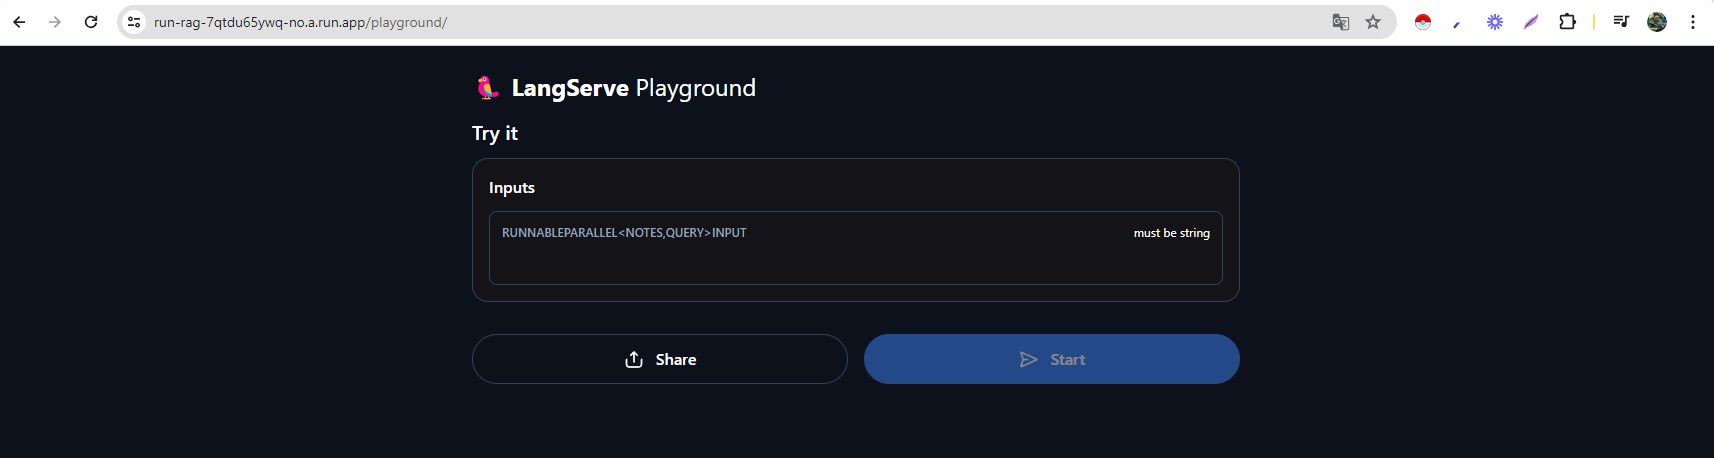

Ya tenemos la aplicación desplegada y accesible públicamente. Si navegas a la URL /playground puedes hacer preguntas acerca de la documentación de Cloud Run, por ejemplo:

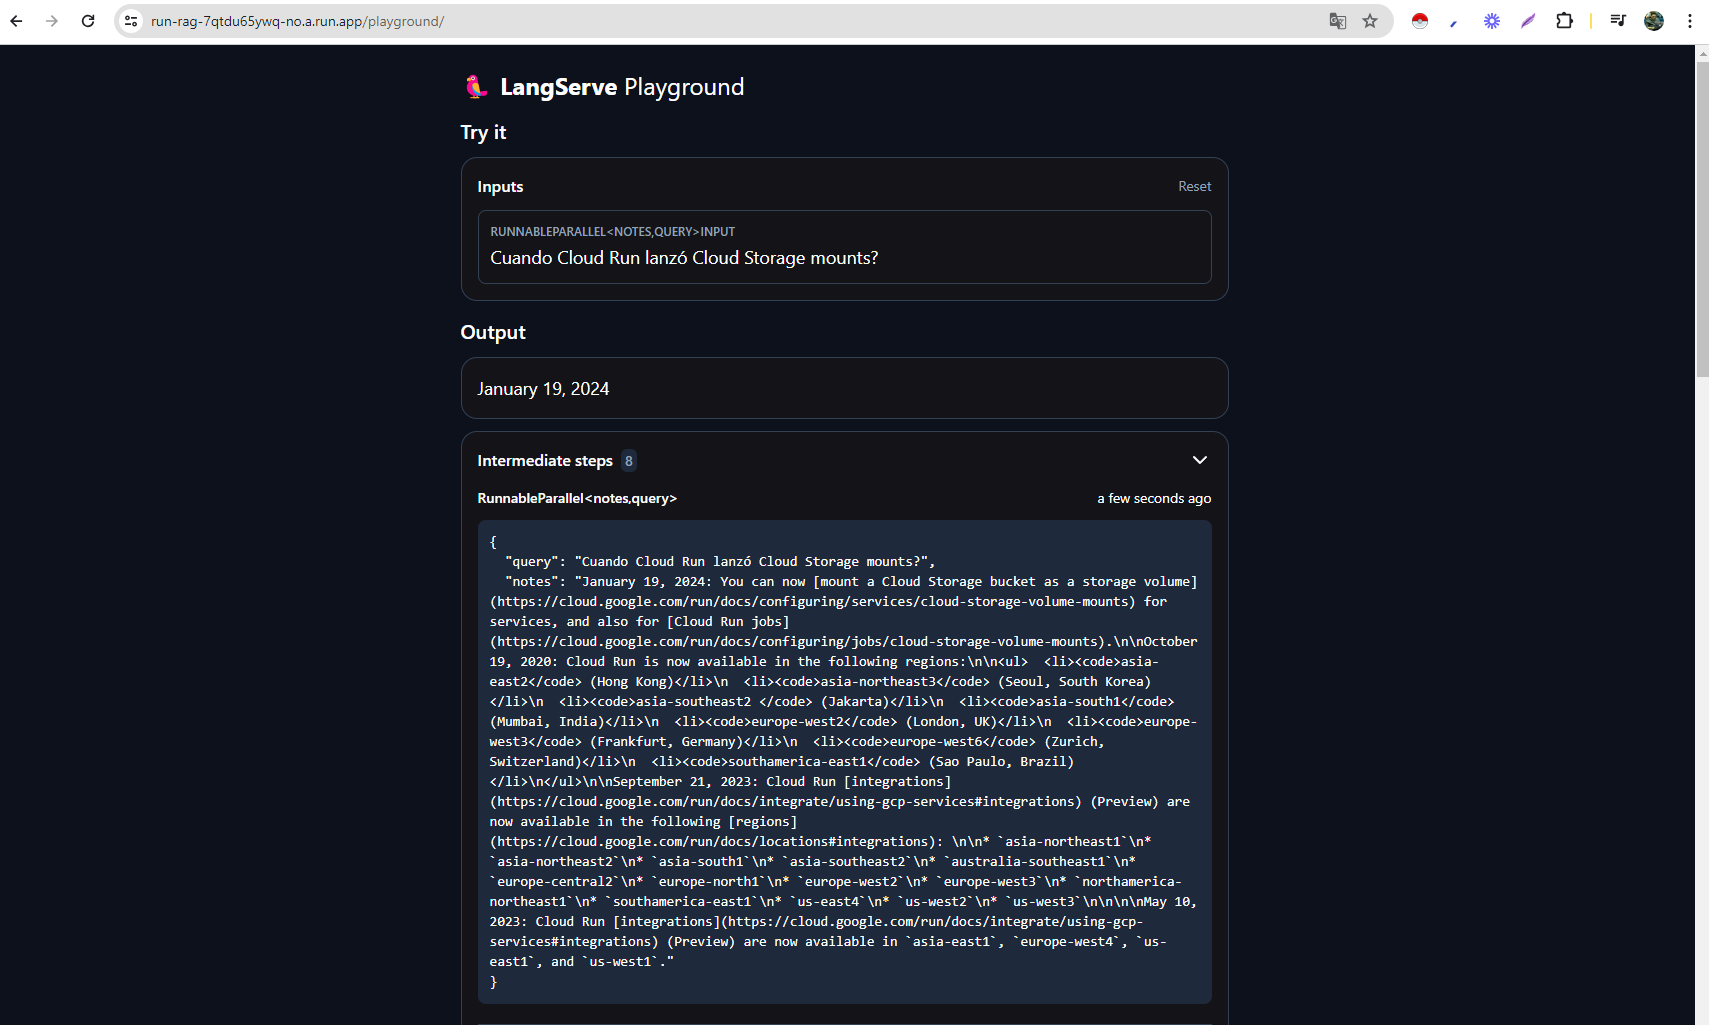

En la siguiente imágen puedes ver como accede a los chunks relevantes para contestar a la pregunta:

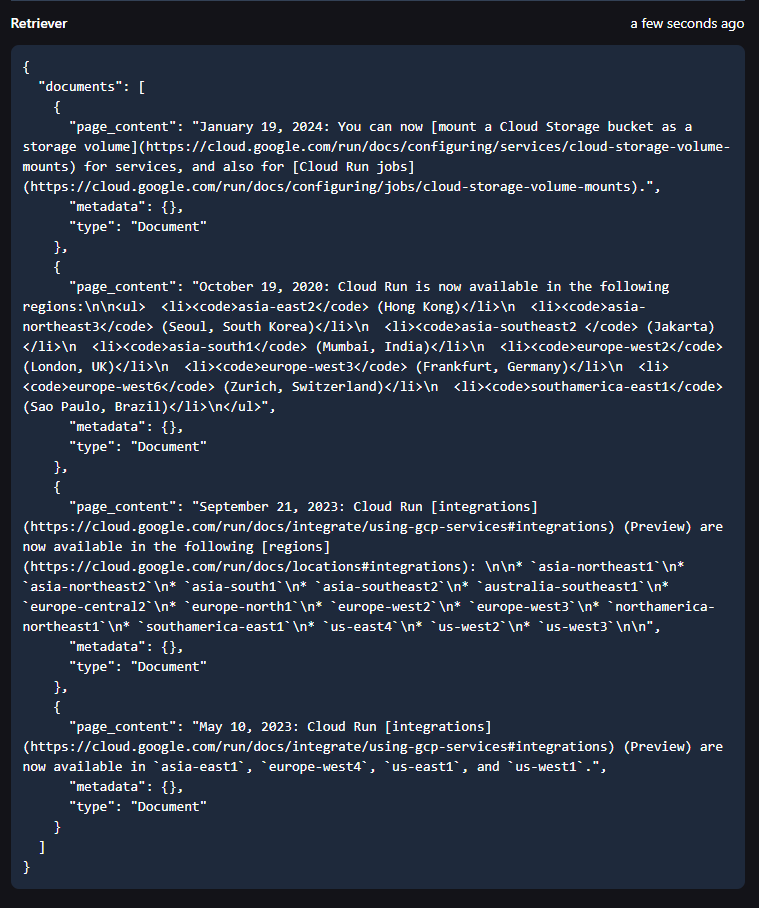

Te dejo el enlace para que puedas trastear un poco: https://run-rag-7qtdu65ywq-no.a.run.app/playground/